#### Step 1: Set up dataset and load two test images, and visualize the patchification.

/usr/local/anaconda3/envs/mixedres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up dataset and dataloader...
loading one batch...
Done. Processing batch...
patch sizes:  dict_keys([14, 28, 56])
Running visualization...
Batch 0:
Expected token number:  576
Actual token number:  441.0
Token fraction:  0.765625
Batch 1:
Expected token number:  576
Actual token number:  420.0
Token fraction:  0.7291666666666666
Batch 2:
Expected token number:  576
Actual token number:  576.0
Token fraction:  1.0
Batch 3:
Expected token number:  576
Actual token number:  573.0
Token fraction:  0.9947916666666666


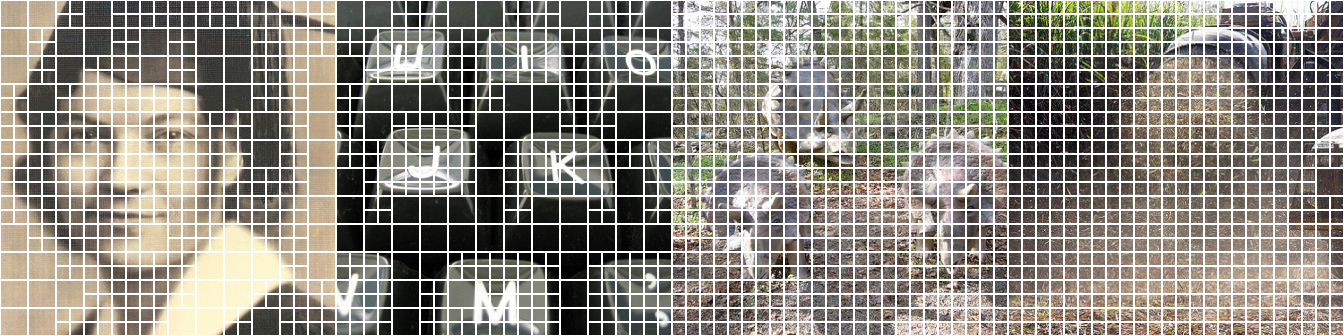

In [ ]:
import sys
sys.path.append("..")
import torch
import einops
import numpy as np
from torchvision import transforms

from torch.utils.data import DataLoader

import PIL.Image as Image

from src.data.transforms import transforms_imagenet_train, transforms_imagenet_eval, ImageFolderWithEntropy
from src.models.entropy_utils import select_patches_by_threshold, visualize_selected_patches_cv2
from src.mse_utils import compute_patch_mse_vectorized, select_patches_by_threshold

# Compute MSE maps for different patch sizes

IMAGE_SIZE = 336
BASE_PATCH_SIZE = 14
NUM_SCALES = 3
THRESHOLDS = [6.0, 4.0]
BATCH_SIZE = 4

print("Setting up dataset and dataloader...")

pre_transform, post_transform = transforms_imagenet_eval(
    img_size=IMAGE_SIZE, 
    mean=[0.5, 0.5, 0.5], 
    std=[0.5, 0.5, 0.5],
    pre_post_divide=True,
    eval_crop_ratio=None 
)
dataset = ImageFolderWithEntropy(
    root="/edrive1/rchoudhu/ILSVRC2012/val",
    transform=(pre_transform, post_transform),
    patch_size=BASE_PATCH_SIZE,
    num_scales=NUM_SCALES)


dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, shuffle=True)

# Get one batch. 
print("loading one batch...")
for idx, batch in enumerate(dataloader): 
    if idx > 0: break

print("Done. Processing batch...")
images, labels, entropy_maps = batch

unnorm = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

# patch_sizes = entropy_maps.keys()
# print("patch sizes: ", patch_sizes)
# masks = select_patches_by_threshold(entropy_maps, thresholds=THRESHOLDS)

# Visualize images
unnormed_images = unnorm(images)
unnormed_images = (unnormed_images * 255).to(torch.uint8)

print("Running visualization...")
vis_imgs = []
vis_masks = {k: v for k, v in masks.items()}
expected_token_count = (IMAGE_SIZE // BASE_PATCH_SIZE) ** 2
actual_token_counts = []
for batch_idx in range(BATCH_SIZE):
    batch_vis_masks = {k: v[batch_idx] for k, v in vis_masks.items()}
    actual_token_count = sum(v.sum().item() for v in batch_vis_masks.values())
    actual_token_counts.append(actual_token_count)

    print(f"Batch {batch_idx}:")
    print("Expected token number: ", expected_token_count)
    print("Actual token number: ", actual_token_count)
    print("Token fraction: ", actual_token_count / expected_token_count)
    vis_img = visualize_selected_patches_cv2(
        image_tensor=unnormed_images[batch_idx],
        masks=batch_vis_masks,
        patch_sizes=list(patch_sizes),
    )
    vis_imgs.append(np.array(vis_img))

# Concatenate images horizontally
final_vis_img = np.concatenate(vis_imgs, axis=1)
final_vis_img = Image.fromarray(final_vis_img)
final_vis_img


#### Step 2: downsize the image twice (once for each scale). Then, use the masks to select anything that's needed.

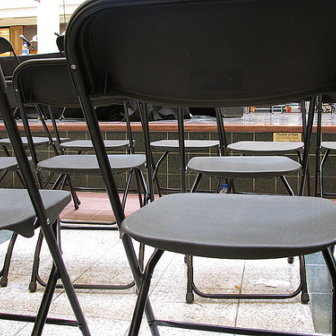

In [3]:
img_np = unnormed_images[0].permute(1, 2, 0).numpy()
pil_img = Image.fromarray(img_np)
pil_img